# Study of systematic errors
To compute the spectral densities from discrete, finite points, we will use a variation of the Backus-Gilbert method (see 1903.064476).
We define the basis functions:
$$b_T(t, \omega) = \omega^2\bigl(e^{-\omega t} + e^{-\omega(T-t)}\bigr)$$
Then we define a functional to minimize:
$$A[g] = \int_{\omega_0}^{+\infty}d\omega\,\bigl(\bar{\Delta}(\omega_*, \omega) - K_{\omega_*}(\omega)\bigr)^2, \qquad \bar{\Delta}(\omega_*, \omega) = \sum_{t = 0}^{t_\mathrm(max)}g_t(\omega_*)b_T(t+1, \omega)$$
This can be rewritten in vector notation:
$$A[g] = \vec g^T A \vec g -2\vec g^T \vec f, \qquad A_{ij}=\int_{\omega_0}^{+\infty}d\omega\,b_T(i+1, \omega)b_T(j+1, \omega), \quad f_i = \int_{\omega_0}^{+\infty}d\omega\, K_{\omega_*}(\omega)b_T(i+1, \omega)$$
Its minimization brings to:
$$ \vec g = A^{-1}\vec f$$
The smeared spectral density is:
$$\rho_K(\omega_*) = \sum_{t = 0}^{t_\mathrm{t_max}} g_t(\omega_*)C(t+1)$$
Now, both the matrix $A$ and $\vec f$ can be computed analytically, the problem will be the inversion of A, and the finiteness of A, so the dependence of $\vec g$ on $t_\mathrm{max}$.

## Definitions of functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import norm
from scipy.special import erfc

In [3]:
#Class for the spectral density

class Spectral_density:
    t_max = 0
    w0 = 0.0
    alpha = 0.0
    A_inv = np.zeros((t_max, t_max))
    def __init__(self, t_max_new = 0, w0_new = 0, alpha_new = 0):
        if Spectral_density.t_max != t_max_new or Spectral_density.w0 != w0_new or Spectral_density.alpha != alpha_new:
            Spectral_density.t_max = t_max_new
            Spectral_density.w0 = w0_new
            Spectral_density.alpha = alpha_new
            #print("New values of t_max ({}), w0 ({}), alpha ({})".format(Spectral_density.t_max, Spectral_density.w0, Spectral_density.alpha))

            Spectral_density.A_inv = np.linalg.inv(self.A_alpha())

    def int_basis(self, a):
        w0 = Spectral_density.w0
        return (w0**4/a + 4.0 * w0**3/a**2 + 12.0 * w0**2/a**3 + 24.0 * w0/a**4 + 24.0/a**5) * np.exp(-a*w0)

    def A_func(self, t, r, T):
        return self.int_basis(t+r+2) + self.int_basis(T+t-r) + self.int_basis(T-t+r) + self.int_basis(2*(T-1)-t-r)

    def A_alpha(self):
        t_max = Spectral_density.t_max
        alpha = Spectral_density.alpha

        T = int(2*t_max)
        A = np.zeros((t_max, t_max))
        for i in range(t_max):
            for j in range(t_max):
                A[i, j] = self.A_func(i, j, T)
        
        Id = np.diag(np.zeros(t_max) + 1)
        return A + alpha*Id

    def f_integral(self, w1, a, sigma):
        w0 = Spectral_density.w0
        n = norm(w1, sigma)
        f = lambda x: x**2.0 * np.exp(-a*x) * n.pdf(x)

        res = np.exp(-a*w0 - (w0-w1)**2/(2*sigma**2.0))/(2*np.sqrt(np.pi))*\
        (np.sqrt(2.)*sigma*(w0+w1-a*sigma**2.0) + \
        np.sqrt(np.pi) * (sigma**2. + (w1-a*sigma**2.)**2.)*np.exp((w0-w1+a*sigma**2.)**2./(2*sigma**2.))*erfc((w0-w1+a*sigma**2.)/(np.sqrt(2.)*sigma)))
        
        if not (np.isnan(res) or res == float('inf')):
            return res
        else:
            return quad(f, w0, +np.inf)[0]
        
        #return 0.5*np.exp(-a*w1)* \
        #(np.sqrt(2.0/np.pi)*(w0**2.0 -(a*(w0+w1) - 2.0)*sigma**2.0 + (a*sigma**2.0)**2.0)/sigma * np.exp(-(w0-w1)*(w0-w1+2.*a*sigma**2.0)/(2*sigma**2.)) -\
        # (w1*(a*w1 - 2.) + a*(3.-2.*a*w1)*sigma**2. + a**3. * sigma**4.)*np.exp(-(a*sigma)**2./2.) * erfc((w0-w1 + a*sigma**2.)/(np.sqrt(2)*sigma)))

    def f_func(self, w1, t, T, sigma):
        return self.f_integral(w1, t+1, sigma) + self.f_integral(w1, T-t-1, sigma)

    def f_vect(self, w1, sigma):
        t_max = Spectral_density.t_max
        
        T = int(2*t_max)
        f = np.zeros(t_max)
        for i in range(len(f)):
            f[i] = self.f_func(w1, i, T, sigma)

        return f
    
    def g(self, w1, sigma):
        return Spectral_density.A_inv @ self.f_vect(w1, sigma)
    
    def rho(self, w1, sigma, corr):
        return self.g(w1, sigma)[0:len(corr)].T @ corr
    
    def rho_err(self, w1, sigma, cov):
        J = self.g(w1, sigma)[0:len(cov[0, :])]
        return np.sqrt(J.T @ cov @ J)
    
#Class of the correlator
class Double_exp:
    def fit_f(self, x, C1, m1, C2, m2):
        return C1 * np.exp(-m1 * x) + C2 * np.exp(-m2 * x)
    
    def f(self, x, par):
        return self.fit_f(x, par[0], par[1], par[2], par[3])
    
    def der0(self, x, par):
        return np.exp(- par[1] * x)
    
    def der1(self, x, par):
        return - par[0] * x * np.exp(- par[1] * x)
    
    def der2(self, x, par):
        return np.exp(- par[3] * x)
    
    def der3(self, x, par):
        return - par[2] * x * np.exp(- par[3] * x)
    
    def jac(self, x, par):
        return np.array([self.der0(x, par), self.der1(x, par), self.der2(x, par), self.der3(x, par)])
    
    def cov_matrix(self, x1, x2, par, cov_par):
        return self.jac(x1, par).T @ cov_par @ self.jac(x2, par)

## Plots of the eigenvalues as a function of $\alpha$

Let's see how alpha is a regulator for the small eigenvalues, to stabilize the algorithm.

Text(0.5, 1.0, 'Eigenvalues of the $A_{rt}$ matrix for several values of $\\alpha$')

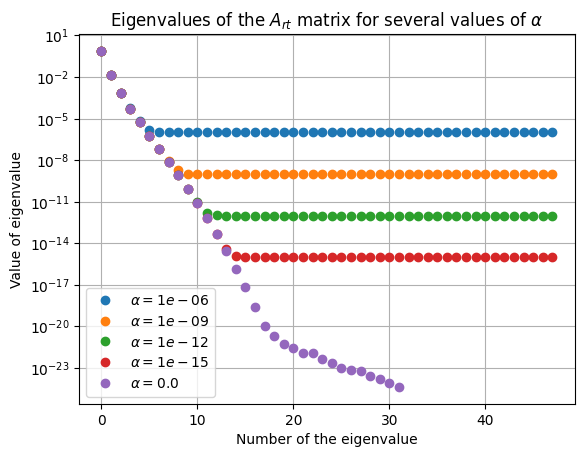

In [3]:
t_max, w0 = 48, 0.1
alpha = [1.0e-6, 1.0e-9, 1.0e-12, 1.0e-15, 0.0]
for a in alpha:
    r = Spectral_density(t_max, w0, a)
    A = r.A_alpha()
    eig, _ = np.linalg.eigh(A)
    plt.plot(range(len(eig)), np.flip(eig), "o", label=r"$\alpha = {}$".format(a))
    plt.semilogy()

plt.legend()
plt.grid()
plt.xlabel("Number of the eigenvalue")
plt.ylabel("Value of eigenvalue")
plt.title(r"Eigenvalues of the $A_{rt}$ matrix for several values of $\alpha$")

## Systematic error due to $t_\mathrm{max}$ of $\vec g$ and $\rho_K(\omega)$ 
Now we want to study the systematic error introduced by the finite $t$. I'll work fixing $\sigma = 67.5$ Mev, $\alpha = 10^{-12}$ and $\omega_* = 0.0$ for several values of $\omega_0$. To do this, I'll use as a reference $t_\mathrm{max} = 10000$, and and I'll plot $|g_{t_\mathrm{max}}/g_{10000} - 1|$ for some values of $t_\mathrm{max}$.

We'll do the same for $|\rho_{t_\mathrm{max}}/\rho_{10000} - 1|$, using several values of $\omega_*$

### Computation of correlators

In [4]:
data = open("out/vector/data/fits/direct_fit_double.txt")
lines = data.readlines()
data.close()

par = []
for l in lines:
    t = l.split()
    if int(t[0]) == 10:
        for i in range(4):
            par.append(float(t[1 + 2*i]))
        break
par = np.array(par)

data = open("out/vector/data/fits/cov.txt")
cov = np.zeros((len(par), len(par)))
for i in range(len(par)):
    for j in range(len(par)):
        cov[i, j] = float(data.readline().split()[0])
data.close()

In [5]:
corr_func = Double_exp()

times = np.arange(1, 48)
corr = corr_func.f(times, par)
cov_corr = np.zeros((len(times), len(times)))
for t1 in times-1:
    for t2 in times-1:
        cov_corr[t1, t2] = corr_func.cov_matrix(t1, t2, par, cov)

### Study of $\vec g$

In [ ]:
alpha = 1e-12
sigma = 135/2. * 0.065 / 197.3
t_ref = 10000
t_max_list = [48, 500, 1000, 2500, 5000]
w0_list = np.array([0.0, 135/2., 135, 270, 270 * 1.5]) * 0.065/197.3
g_vect = np.zeros((len(w0_list), len(t_max_list), 48))

for i in range(len(w0_list)):
    rif = Spectral_density(t_ref, w0_list[i], alpha)
    g_rif = rif.g(0.0, sigma)
    for j in range(len(t_max_list)):
        r = Spectral_density(t_max_list[j], w0_list[i], alpha)
        g_vect[i, j, :] = np.abs(r.g(0.0, sigma)[0:48] / g_rif[0:48] - 1.0)

/tmp/ipykernel_1373638/1198931002.py:44: RuntimeWarning: overflow encountered in exp
  np.sqrt(np.pi) * (sigma**2. + (w1-a*sigma**2.)**2.)*np.exp((w0-w1+a*sigma**2.)**2./(2*sigma**2.))*erfc((w0-w1+a*sigma**2.)/(np.sqrt(2.)*sigma)))
/tmp/ipykernel_1373638/1198931002.py:44: RuntimeWarning: invalid value encountered in scalar multiply
  np.sqrt(np.pi) * (sigma**2. + (w1-a*sigma**2.)**2.)*np.exp((w0-w1+a*sigma**2.)**2./(2*sigma**2.))*erfc((w0-w1+a*sigma**2.)/(np.sqrt(2.)*sigma)))


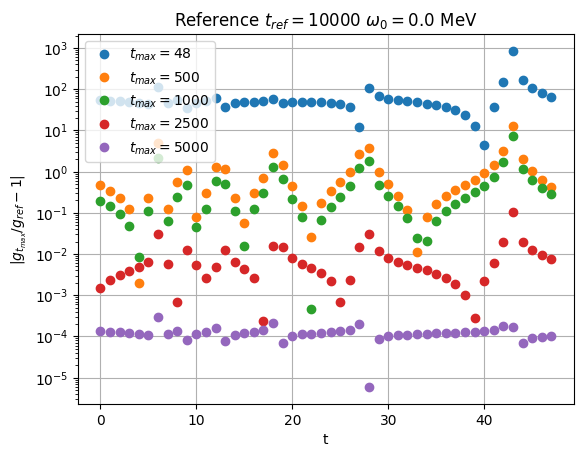

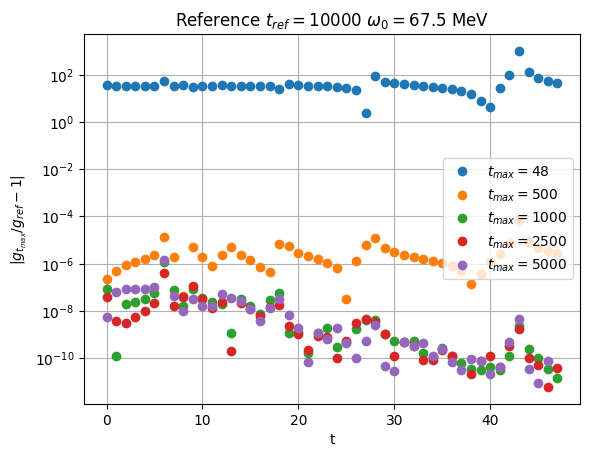

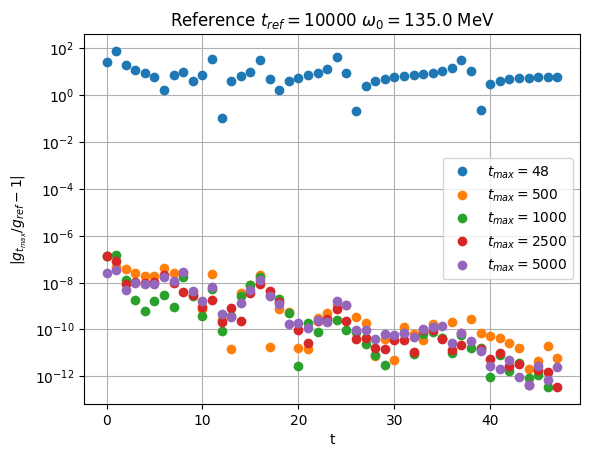

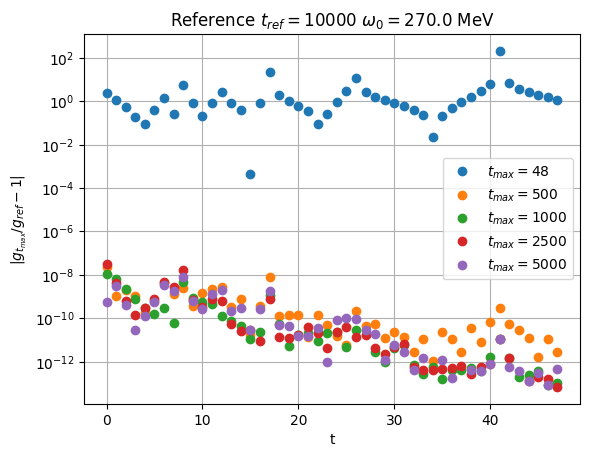

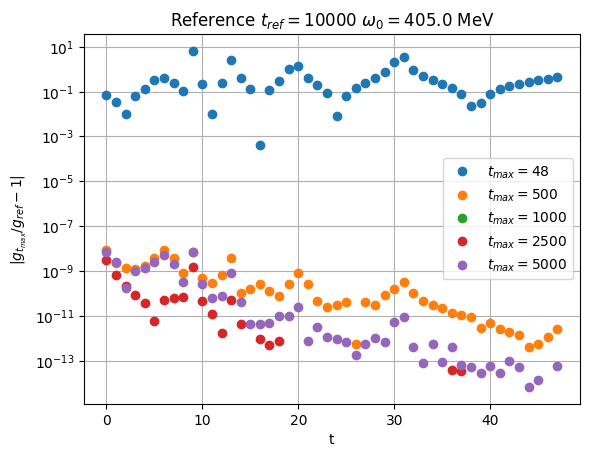

In [12]:
w0_list = [0.0, 135/2., 135., 270., 270. * 1.5]
for i in range(len(w0_list)):
    for j in range(len(t_max_list)):
        plt.plot(range(len(g_vect[i, j, :])), g_vect[i, j, :], "o", label = r"$t_{max} = $" + "{}".format(t_max_list[j]))
    plt.title(r"Reference $t_{ref}$" + r"$= {}$".format(t_ref) + " $\omega_0 = {}$ MeV".format(w0_list[i]))
    plt.legend()
    plt.semilogy()
    plt.grid()
    plt.xlabel("t")
    plt.ylabel(r"$|g_{t_{max}} / g_{ref} - 1|$")
    plt.savefig("out/vector/plots/rho/g_coeff_w0_{}.png".format(i))
    plt.show()

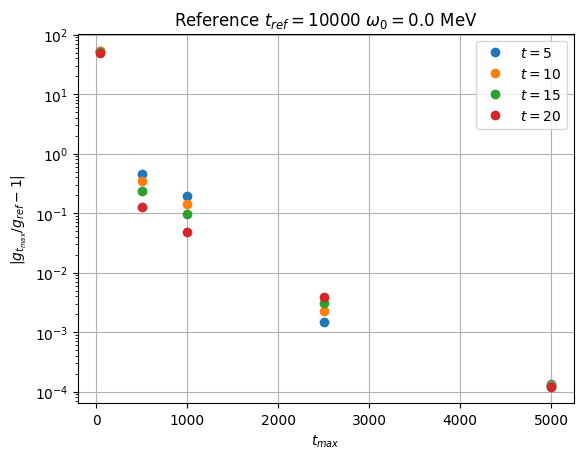

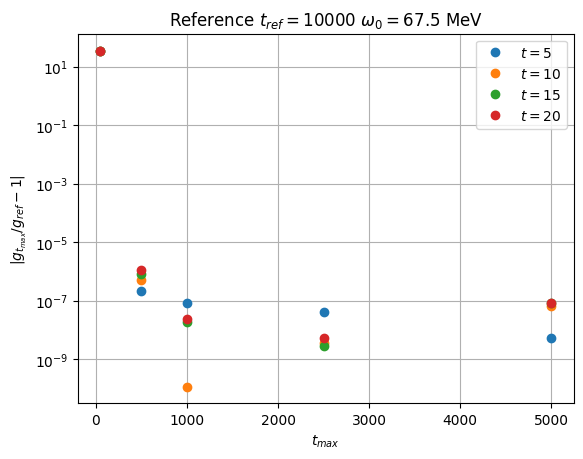

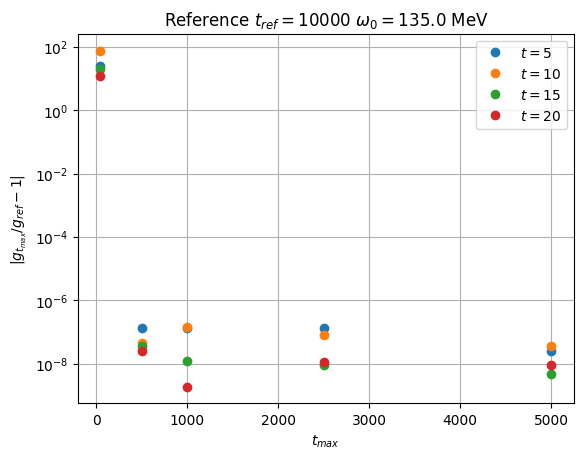

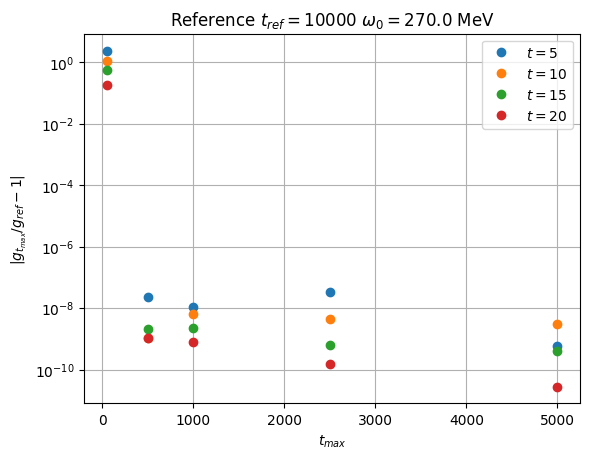

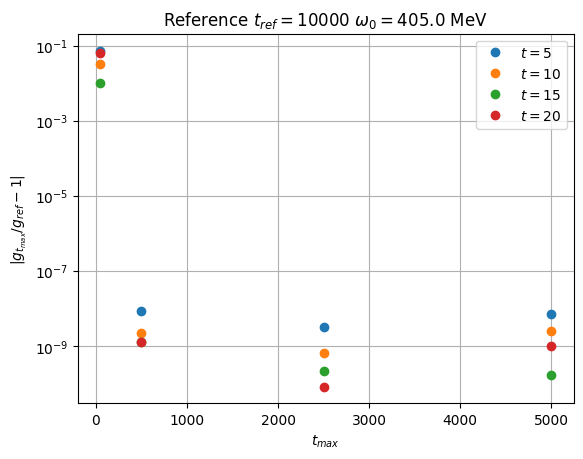

In [15]:
w0_list = [0.0, 135/2., 135., 270., 270. * 1.5]
t_to_plot = [5, 10, 15, 20]
for i in range(len(w0_list)):
    for j in range(len(t_to_plot)):
        plt.plot(t_max_list, g_vect[i, :, j], "o", label = r"$t = $" + "{}".format(t_to_plot[j]))
    plt.title(r"Reference $t_{ref}$" + r"$= {}$".format(t_ref) + " $\omega_0 = {}$ MeV".format(w0_list[i]))
    plt.legend()
    plt.semilogy()
    plt.grid()
    plt.xlabel(r"$t_{max}$")
    plt.ylabel(r"$|g_{t_{max}} / g_{ref} - 1|$")
    plt.savefig("out/vector/plots/rho/g_coeff_w0_{}_vs_tmax.png".format(i))
    plt.show()

### Study of $\rho$

In [6]:
alpha = 1e-12
sigma = 135/2. * 0.065 / 197.3
t_ref = 10000
#t_max_list = [48, 50, 70, 90]
t_max_list = [48, 100, 200, 500, 1000]
w1_list = [0.0, 0.25, 0.5, 0.75, 1.0]
w0_list = np.array([1.5*270, 1.8*270]) * 0.065/197.3
rho = np.zeros((len(w0_list), len(t_max_list), len(w1_list)))
rho_err = np.zeros((len(w0_list), len(t_max_list), len(w1_list)))
err_ratio = np.zeros((len(w0_list), len(t_max_list), len(w1_list)))

for i in range(len(w0_list)):
    rif = Spectral_density(t_ref, w0_list[i], alpha)
    r_rif = np.zeros(0)
    r_rif_err = np.zeros(0)
    for j in range(len(w1_list)):
        r_rif = np.append(r_rif, rif.rho(w1_list[j], sigma, corr))
        r_rif_err = np.append(r_rif_err, rif.rho_err(w1_list[j], sigma, cov_corr))
    for j in range(len(t_max_list)):
        r = Spectral_density(t_max_list[j], w0_list[i], alpha)
        for k in range(len(w1_list)):
            rho[i, j, k] = np.abs(r.rho(w1_list[k], sigma, corr) / r_rif[k] - 1.0)
            rho_err[i, j, k] = np.abs(r.rho_err(w1_list[k], sigma, cov_corr) / r_rif_err[k] - 1.0)
            err_ratio[i, j, k] = np.sqrt((rho_err[i, j, k] / rho[i, j, k]) ** 2.0 + (r_rif_err[k] / r_rif[k]) ** 2.0)

/tmp/ipykernel_3881114/1198931002.py:44: RuntimeWarning: overflow encountered in exp
  np.sqrt(np.pi) * (sigma**2. + (w1-a*sigma**2.)**2.)*np.exp((w0-w1+a*sigma**2.)**2./(2*sigma**2.))*erfc((w0-w1+a*sigma**2.)/(np.sqrt(2.)*sigma)))
/tmp/ipykernel_3881114/1198931002.py:44: RuntimeWarning: invalid value encountered in scalar multiply
  np.sqrt(np.pi) * (sigma**2. + (w1-a*sigma**2.)**2.)*np.exp((w0-w1+a*sigma**2.)**2./(2*sigma**2.))*erfc((w0-w1+a*sigma**2.)/(np.sqrt(2.)*sigma)))
/tmp/ipykernel_3881114/1198931002.py:42: RuntimeWarning: invalid value encountered in scalar multiply
  res = np.exp(-a*w0 - (w0-w1)**2/(2*sigma**2.0))/(2*np.sqrt(np.pi))*\
/tmp/ipykernel_3881114/1198931002.py:44: RuntimeWarning: overflow encountered in scalar multiply
  np.sqrt(np.pi) * (sigma**2. + (w1-a*sigma**2.)**2.)*np.exp((w0-w1+a*sigma**2.)**2./(2*sigma**2.))*erfc((w0-w1+a*sigma**2.)/(np.sqrt(2.)*sigma)))
/tmp/ipykernel_3881114/3559336016.py:24: RuntimeWarning: invalid value encountered in scalar divide
  

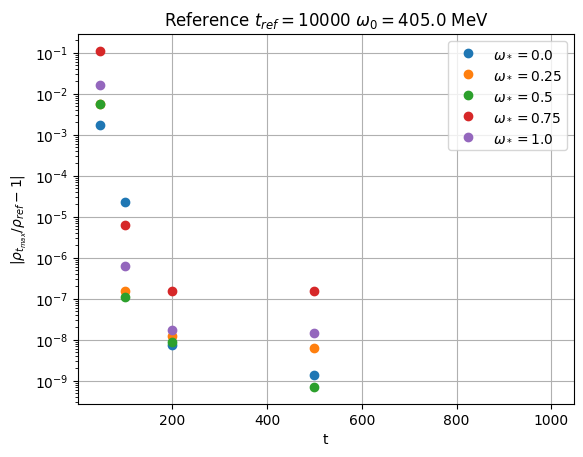

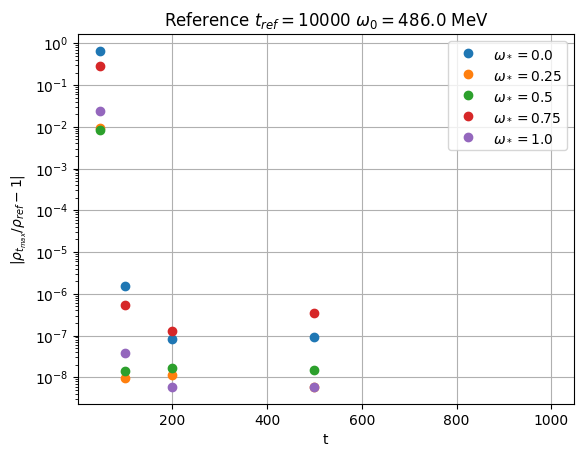

In [7]:
w0_list = [1.5*270, 1.8*270]
for i in range(len(w0_list)):
    for j in range(len(w1_list)):
        plt.plot(t_max_list, rho[i, :, j], "o", label = r"$\omega_* = $" + "{}".format(w1_list[j]))
    plt.title(r"Reference $t_{ref}$" + r"$= {}$".format(t_ref) + " $\omega_0 = {}$ MeV".format(w0_list[i]))
    plt.legend()
    plt.semilogy()
    plt.grid()
    plt.xlabel("t")
    plt.ylabel(r"$|\rho_{t_{max}} / \rho_{ref} - 1|$")
    plt.savefig("out/vector/plots/rho/rho_sys_w0_{}.png".format(i+4))
    plt.show()

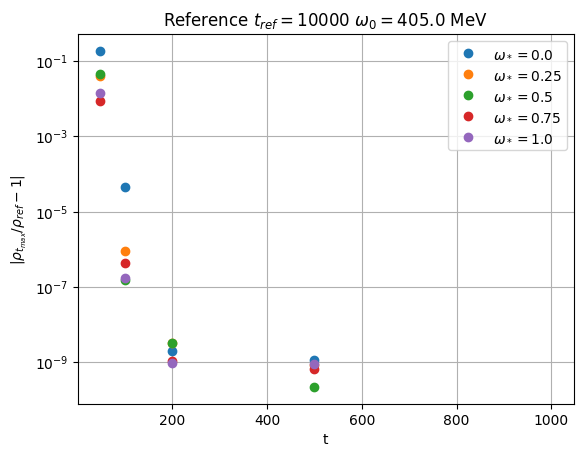

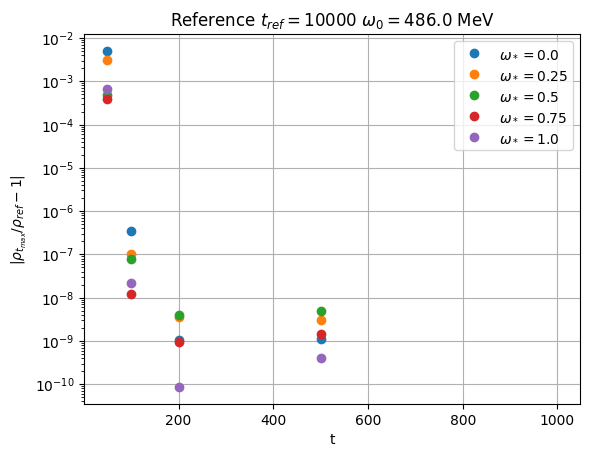

In [8]:
w0_list = [1.5*270, 1.8*270]
for i in range(len(w0_list)):
    for j in range(len(w1_list)):
        plt.plot(t_max_list, rho_err[i, :, j], "o", label = r"$\omega_* = $" + "{}".format(w1_list[j]))
    plt.title(r"Reference $t_{ref}$" + r"$= {}$".format(t_ref) + " $\omega_0 = {}$ MeV".format(w0_list[i]))
    plt.legend()
    plt.semilogy()
    plt.grid()
    plt.xlabel("t")
    plt.ylabel(r"$|\rho_{t_{max}} / \rho_{ref} - 1|$")
    plt.savefig("out/vector/plots/rho/rho_err_sys_w0_{}.png".format(i+4))
    plt.show()

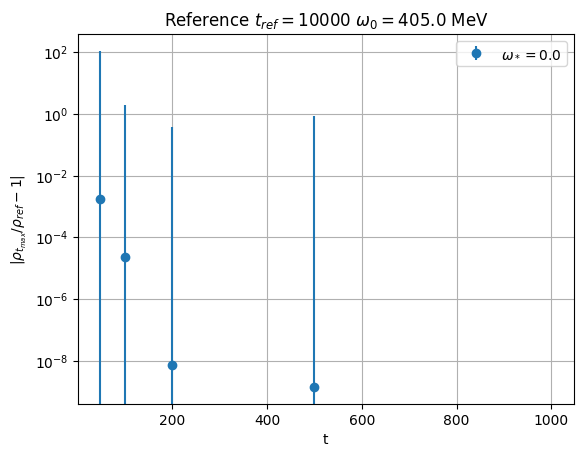

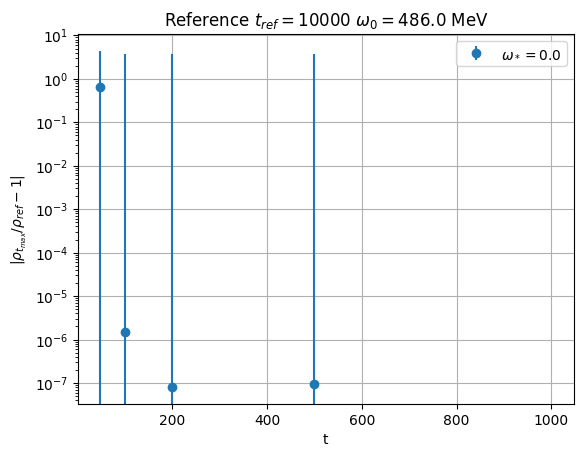

In [9]:
w0_list = [1.5*270, 1.8*270]
for i in range(len(w0_list)):
    for j in range(1):
        plt.errorbar(t_max_list, rho[i, :, j], err_ratio[i, :, j], fmt="o", label = r"$\omega_* = $" + "{}".format(w1_list[j]))
    plt.title(r"Reference $t_{ref}$" + r"$= {}$".format(t_ref) + " $\omega_0 = {}$ MeV".format(w0_list[i]))
    plt.legend()
    plt.semilogy()
    plt.grid()
    plt.xlabel("t")
    plt.ylabel(r"$|\rho_{t_{max}} / \rho_{ref} - 1|$")
    plt.savefig("out/vector/plots/rho/rho_sys_w0_{}_err.png".format(i+4))
    plt.show()

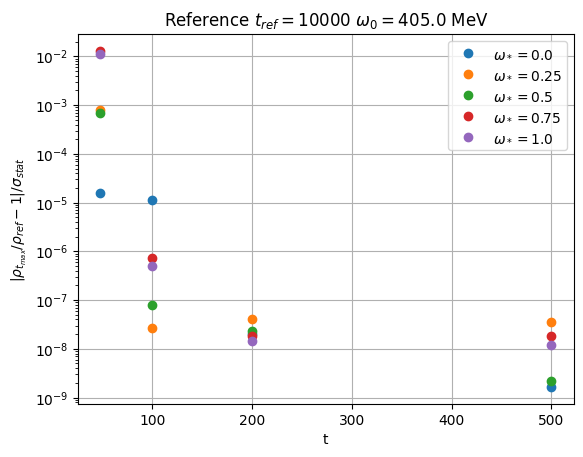

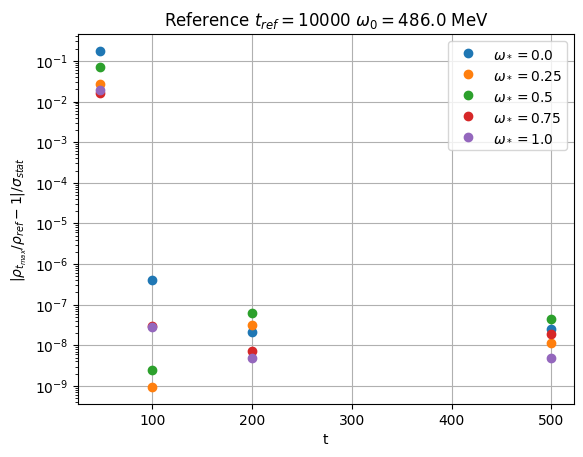

In [10]:
w0_list = [1.5*270, 1.8*270]
for i in range(len(w0_list)):
    for j in range(len(w1_list)):
        plt.plot(t_max_list, rho[i, :, j]/err_ratio[i, :, j], "o", label = r"$\omega_* = $" + "{}".format(w1_list[j]))
    plt.title(r"Reference $t_{ref}$" + r"$= {}$".format(t_ref) + " $\omega_0 = {}$ MeV".format(w0_list[i]))
    plt.legend()
    plt.semilogy()
    plt.grid()
    plt.xlabel("t")
    plt.ylabel(r"$|\rho_{t_{max}} / \rho_{ref} - 1| / \sigma_{stat}$")
    plt.savefig("out/vector/plots/rho/rho_sys_w0_{}_ratio_err.png".format(i+4))
    plt.show()

## Plot of $\vec g$

In [ ]:
w0_list = [0.0, 0.05, 0.1, 0.15]
t_max_list = [48, 75, 100, 200, 300]
w1_list = [0.0]
alpha_list = [1.0e-6, 1.0e-9, 1.0e-12]
sigma_list = np.array([135.0/2., 135, 270, 540, 810]) * 0.065 /197.3

g_vect = np.zeros((len(w0_list), len(alpha_list), len(t_max_list), len(sigma_list), len(w1_list), 48))
for w0 in range(len(w0_list)):
    for alpha in range(len(alpha_list)):   
        for t_max in range(len(t_max_list)):
            r = Spectral_density(t_max_list[t_max], w0_list[w0], alpha_list[alpha])
            for sigma in range(len(sigma_list)):
                for w1 in range(len(w1_list)):
                    g_vect[w0, alpha, t_max, sigma, w1, :] = r.g(w1_list[w1], sigma_list[sigma])[0:48]

In [ ]:
sigma_list = np.array([135.0/2., 135, 270, 540, 810])
for w1 in range(len(w1_list)):
    for alpha in range(len(alpha_list)):    
        for sigma in range(len(sigma_list)):
            for w0 in range(len(w0_list)):
                for t_max in range(len(t_max_list)):                   
                    plt.plot(range(len(g_vect[w0, alpha, t_max, sigma, w1, :])), g_vect[w0, alpha, t_max, sigma, w1, :], "o", label = r"$t_{max} = $" + "{}".format(t_max_list[t_max]))
                plt.legend()
                plt.title(r"$\omega_1 = {}$, $\sigma = {}$, $\alpha = {}$, $\omega_0 = {}$".format(w1_list[w1], sigma_list[sigma], alpha_list[alpha], w0_list[w0]))
                plt.show()

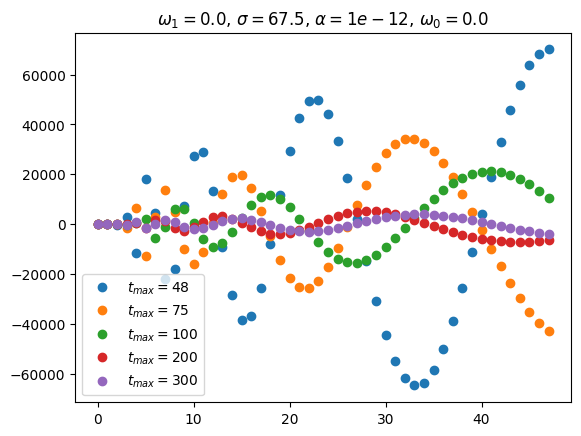

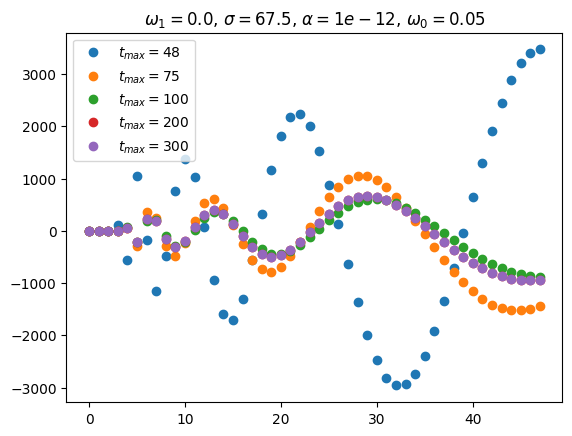

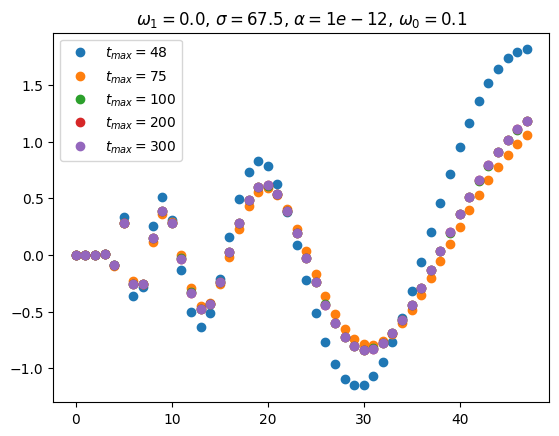

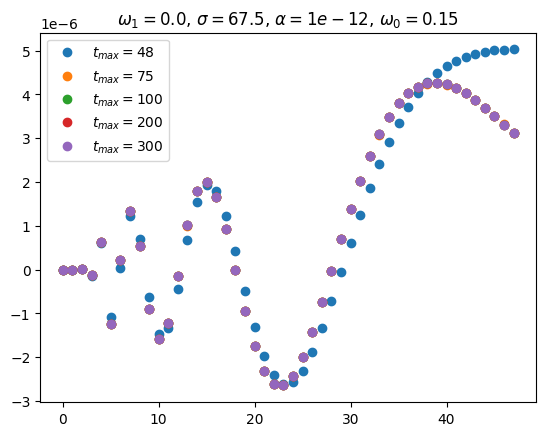

In [22]:
sigma_list = np.array([135.0/2., 135, 270, 540, 810])

for w0 in range(len(w0_list)):
    for t_max in range(len(t_max_list)):                   
        plt.plot(range(len(g_vect[w0, 2, t_max, 0, 0, :])), g_vect[w0, 2, t_max, 0, 0, :], "o", label = r"$t_{max} = $" + "{}".format(t_max_list[t_max]))
    plt.legend()
    plt.title(r"$\omega_1 = {}$, $\sigma = {}$, $\alpha = {}$, $\omega_0 = {}$".format(w1_list[0], sigma_list[0], alpha_list[2], w0_list[w0]))
    plt.show()